In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import numpy as np
import pandas as pd

### Обобщенная схема модели

$s_u$ - вектор сессии полученный как ембеддинг графа сессии пользователя

$f_u$ - предобработанный вектор пользовательских признаков

$r_u$ - вектор агрегированных признаков от ближайших пользователей

$z = Predictor(s_u || f_u || r_u)$ - предсказание модели на конкатенации полученных векторных представлений

Основная проблема: множество пользователей с отсутствием каких-либо данных, решаем извлечением хоть какой-то информации из разных блоков

In [3]:
from sklearn.decomposition import FastICA
import pickle

transformer_filename = 'FastICATransformer'

class SessionNodeEncoderBlock():
    """
    Блок, отвечающий за преобразование строковых представлений состояний в векторные эмбеддинги
    """
    def __init__(self):
        super().__init__()
        
    def forward():
        pass


class SessionSummarizationBlock(nn.Module):
    """
    Блок, отвечающий за преобзраование графа состояний сессии в вектор
    """
    def __init__(self):
        super().__init__()
        
    def forward():
        pass

def user_features_to_low_dimension_tensor(X: np.ndarray):
    """
    Трансформирует набор исходных вещественных фичей в тензор низкой размерности
    """
    with open('FastICATransformer', 'rb') as tfile:
        FastICA = pickle.load(tfile)
    X = FastICA.transform(X)
    return torch.from_numpy(X)
    

class FriendsAggregationBlock(nn.Module):
    """
    Блок, агрегирующий признаки похожих пользователей в один вектор
    """
    def __init__(self, in_features, hid_features, out_features):
        super().__init__()
        self.linear_in = nn.Linear(in_features, hid_features)
        self.linear_out = nn.Linear(hid_features, out_features)
    
    def forward(self, x):
        x_hid = F.relu(self.linear_in(x))
        x_out = self.linear_out(x_hid)
        return x_out

    
class Predictor(nn.Module):
    """
    Голова предсказания, предсказывает логит значения вероятностей для пользователей.
    """
    def __init__(self):
        super().__init__()
        self.friends_agr_block = FriendsAggregationBlock(2028, 512, 64)
        self.output_layer = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, uf=None, ff=None, graph_emb=None):
        #friends_features_embed = self.friends_agr_block(ff)
        #concat_embed = torch.cat((uf, friends_features_embed), axis=1)
        concat_embed = uf
        z = self.output_layer(concat_embed)
        return z
        
        
@torch.no_grad()
def get_probs(z):
    return torch.sigmoid(z)

# По мере того как блоки будут обучатся, сюда подставлять код.
# Блок енкодера строковых предствалений предобучается на графовых структурах состояний (в теории)
# В качесте Predictor-a может быть использована любая модель (MLP, gb, ...)

In [6]:
! ls ../data

FINAL_ALL_SEQUENCES_TRAINTEST.tsv  archive  pXE_
FINAL_FEATURES_FRIENDS.tsv	   pSS_     processed
FINAL_FEATURES_TRAINTEST.tsv	   pTTE     seq_pair_count.csv
FINAL_SEQUENCES_MATRIX.csv	   pTTQL
FINAL_TARGETS_DATES_TRAINTEST.tsv  pTTSL


# Преодработка данных для обучения

In [29]:
# Загрузить табличку с user_id, target (0, 1, test)
# Разделить на две таблички с 0/1 и test в target - на первой обучение, на второй предсказания для submit-а
# Сделать train/test слипт по размеченным данным

# Пайплайн предсказания:
# По user_id сформировать сделать join табличек с необходимыми признаками на вход каждой подмодели
# Строки с Nan-ами заполнить значениями по умолчанию, запомнить соотв. user_id
# На выходах подмодели обнулить выученные представления по user_id для избежания зашумленности (?)
# Сформировать предсказание поверх конкатенации/суммы представлений
# Если у user_id отсутствуют данные во всех таблицах, предскзаать baseline вероятность

In [4]:
user_target_df = pd.read_csv('../data/FINAL_TARGETS_DATES_TRAINTEST.tsv', sep='\t').drop('RETRO_DT', axis=1)
user_target_df.head(5)

,CLIENT_ID,TARGET
0,1011725,0
1,1018784,1
2,1021812,0
3,1024003,0
4,1025140,test


In [5]:
training_user_target_df = user_target_df[user_target_df['TARGET'] != 'test'].reset_index(drop=True)
submit_user_target_df = user_target_df[user_target_df['TARGET'] == 'test'].reset_index(drop=True)
training_user_target_df.shape, submit_user_target_df.shape

((127432, 2), (31858, 2))

In [6]:
training_user_target_df

,CLIENT_ID,TARGET
0,1011725,0
1,1018784,1
2,1021812,0
3,1024003,0
4,1026390,1
...,...,...
127427,72630,0
127428,72633,0
127429,72634,1
127430,72641,0


In [50]:
USER_FEATURES_FILE = '../data/FINAL_FEATURES_TRAINTEST.tsv'
FRIENDS_FEATURES_FILE = '../data/csv'
def get_user_features(clientid_df, uf_path=USER_FEATURES_FILE, with_target=True):
    """
    for training we return X, y, clients_index_with_no_features
    for testing we return X, clients_index_with_no_features
    """
    uf_df = pd.read_csv(uf_path, sep='\t', index_col=0)
    if with_target:
        merged_df = clientid_df.merge(uf_df, how='left', left_on='CLIENT_ID', right_index=True)
        targets = merged_df[['TARGET']]
        features = merged_df.drop(['TARGET', 'CLIENT_ID'], axis=1)
        client_ids_without_features = features.index[features.isnull().any(1)]
        features = features.fillna(0.)
        return features, targets, client_ids_without_features
    else:
        merged_df = clientid_df.merge(uf_df, how='left', left_on='CLIENT_ID', right_index=True)
        features = merged_df.drop(['TARGET', 'CLIENT_ID'], axis=1)
        client_ids_without_features = features.index[features.isnull().any(1)]
        features = features.fillna(0.)
        return features, client_ids_without_features
    
def get_user_friends_features(clientid_df, friends_feat_path=FRIENDS_FEATURES_FILE, with_target=True):
    """
    for training returns X, y, clients_index_with_no_friends
    for testing returns X, clients_index_with_no_friends
    
    friends_features includes both friends and user features appended
    """
    ff_df = pd.read_csv(friends_feat_path, index_col=0)
    if with_target:
        merged_df = merged_df = clientid_df.merge(ff_df, how='left', left_on='CLIENT_ID', right_index=True)
        targets = merged_df[['TARGET']]
        features = merged_df.drop(['TARGET', 'CLIENT_ID'], axis=1)
        client_ids_without_features = features.index[features.isnull().any(1)]
        features = features.fillna(0.)
        return features, targets, client_ids_without_features
    else:
        merged_df = clientid_df.merge(uf_df, how='left', left_on='CLIENT_ID', right_index=True)
        features = merged_df.drop('TARGET', axis=1)
        client_ids_without_features = features.index[features.isnull().any(1)]
        features = features.fillna(0.)
        return features, client_ids_without_features

# Обучение


In [35]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def train_epoch(model, uf, y, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    loss_val = 0.
    aucroc = 0.
    out = model(uf=uf)
    loss = criterion(out, y.to(torch.float))
    
    loss.backward()
    optimizer.step()
    
    loss_val = loss.item()
    aucroc = roc_auc_score(y.detach(), out.detach()).item()
    return loss_val, aucroc

@torch.no_grad()
def eval_epoch(model, uf, y, criterion):
    model.eval()
    loss_val = 0.
    aucroc = 0.
    out = model(uf=uf)
    loss = criterion(out, y.to(torch.float))
    
    loss_val = loss.item()
    aucroc = roc_auc_score(y.detach(), out.detach()).item()
    return loss_val, aucroc

import matplotlib.pyplot as plt
def plot_hist(train_hist):
    train_loss_hist, train_aucroc_hist = train_hist
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.plot(train_loss_hist, label='train loss')
    ax1.set_title('Loss plot')
    ax1.legend()
    ax2.plot(train_aucroc_hist, label='train aucroc')
    ax2.set_title('Training Metric (F1-Score)')
    ax2.legend()
    plt.show()

def train_model(model,
                uf,
                y_train,
                criterion,
                optimizer,
                epochs=100):
    train_loss_hist = []
    train_auc_hist = []
    
    with tqdm(range(1, epochs + 1)) as tepoch:
        for e in tepoch:
            model.train()
            tr_loss, tr_auc = train_epoch(model, uf, y_train, criterion, optimizer)
            train_loss_hist.append(tr_loss)
            train_auc_hist.append(tr_auc)
    
    return train_loss_hist, train_auc_hist

In [14]:
from sklearn.model_selection import train_test_split

user_features, y, clients_without_features = get_user_features(training_user_target_df, with_target=True)

uf_train, uf_test, y_train, y_test = train_test_split(user_features, y, train_size=0.85, stratify=y)

# Подготовка масок для зануления
clients_without_features_in_train = clients_without_features[clients_without_features < len(uf_train)]
clients_without_features_in_test = clients_without_features[clients_without_features > len(uf_train)] - len(uf_train)

# Получение исходных представлений сжатых данных
uf_train_tensor = user_features_to_low_dimension_tensor(uf_train).to(torch.float)
uf_train_tensor[clients_without_features_in_train] = 0.
uf_test_tensor = user_features_to_low_dimension_tensor(uf_test).to(torch.float)
uf_test_tensor[clients_without_features_in_test] = 0.

In [ ]:
# Получение эмбедингов
friends_featues, clients_without_friends = get_user_friends_features()

ff_tain, ff_test, y_train, y_test = train_test_split(friends_features, y, train_size=0.85, stratify=y)

#Подготовка масок для зануления несостоятельных оценок
clients_without_friends_in_train = clients_without_features[clients_without_features < len(X_train)]
clients_without_friends_in_test = clients_without_features[clients_without_features > len(X_train)] - len(X_train)

In [32]:
from torch.nn import BCEWithLogitsLoss

model = Predictor()

uf_train = uf_train_tensor
uf_test = uf_test_tensor
# ff_train = ff_train_tensor
# ff_test = ff_test_tensor

# y_train = torch.from_numpy(y_train.astype(int).values).to(int)
# y_test = torch.from_numpy(y_test.astype(int).values).to(int)

criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

hist = train_model(model, uf_train, y_train, criterion, optimizer, epochs=500)

100%|██████████| 500/500 [02:45<00:00,  3.03it/s]


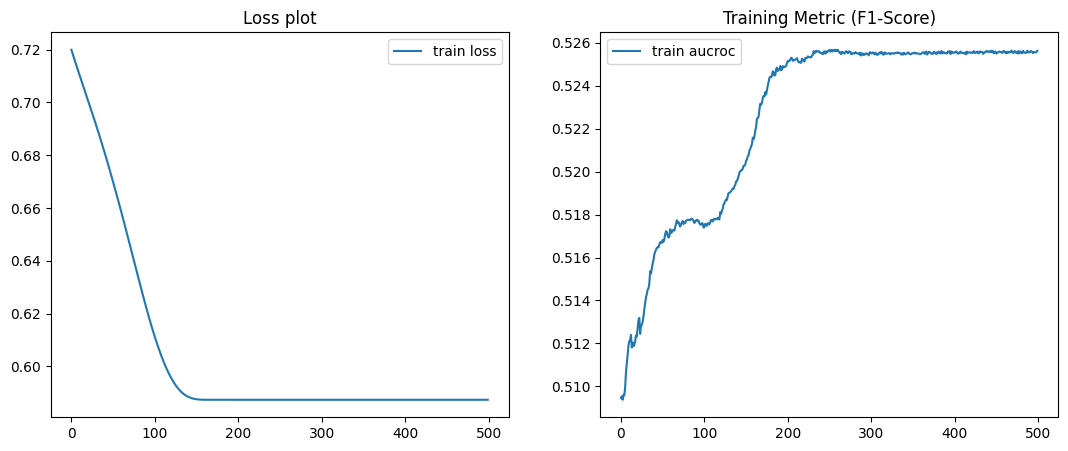

In [33]:
plot_hist(hist)

In [36]:
eval_epoch(model, uf_test, y_test, criterion)

(0.5873740911483765, 0.5025345521859078)

In [ ]:
torch.save(model.state_dict(), 'best_model_on_test.pth')

# Дообучение на всей выборке


In [41]:
user_features, y, clients_without_features = get_user_features(training_user_target_df, with_target=True)


# Получение исходных представлений сжатых данных
uf_tensor = user_features_to_low_dimension_tensor(user_features).to(torch.float)
uf_tensor[clients_without_features] = 0. 
y = torch.from_numpy(y.astype(int).values)

In [ ]:
from torch.nn import BCEWithLogitsLoss

model = Predictor()

uf = uf_tensor
y = y

criterion = BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

hist = train_model(model, uf_train, y_train, criterion, optimizer, epochs=500)

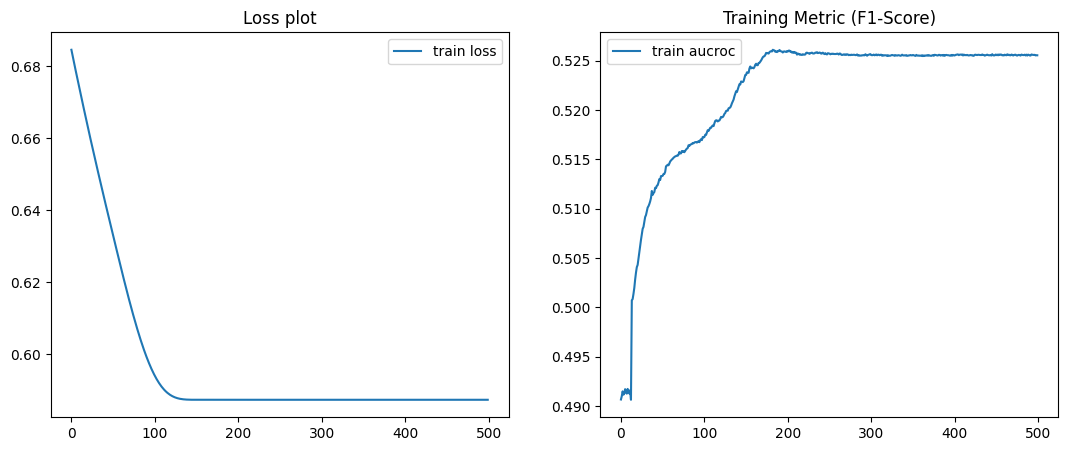

In [43]:
plot_hist(hist)

In [44]:
torch.save(model.state_dict(), 'best_model_on_test.pth')

# Предсказание test и submit

In [45]:
BEST_MODEL_PATH = 'best_model_on_test.pth'

final_model = Predictor()
final_model.load_state_dict(torch.load(BEST_MODEL_PATH))

<All keys matched successfully>

In [56]:
uf_submit, user_without_features = get_user_features(submit_user_target_df, with_target=False)
uf_tensor = user_features_to_low_dimension_tensor(uf_submit).to(torch.float)
uf_tensor[user_without_features] = 0.
# and other features

final_model.eval()
out = final_model(uf=uf_tensor)
probs = get_probs(out)

In [59]:
submission_df = pd.read_csv('../sample_submission.csv')
submission_df['TARGET'] = probs.squeeze(-1).tolist()
submission_df.head()
submission_df.to_csv('submission.csv', index=False)